# Setting up the Simple `T`

In [1]:
from phi.tf.flow import *  # Causes deprecation warnings with TF 1.15
import pylab
session = Session(None)  # Used to run the TensorFlow graph

%load_ext autoreload
%autoreload 2

Could not load resample cuda libraries: CUDA binaries not found at /home/intergalactic-mammoth/anaconda3/envs/tf/lib/python3.7/site-packages/phi/tf/cuda/build/resample.so. Run "python setup.py cuda" to compile them







In [ ]:
#setup

save_imgs = False
res = 32
buoyancy = 0.0
rate = 8

In [2]:
#Create 2 batch sim, target and source blob
#buoyancy is set to zero

world = World()
fluid = world.add(Fluid(Domain([48, 32], boundaries=CLOSED), buoyancy_factor=0.0), physics=IncompressibleFlow())
world.add(Inflow(Sphere(center=[6,16], radius=3), rate=8));
fluid.velocity = variable(fluid.velocity)  # create TensorFlow variable
states = []
states.append(fluid.state)  # Remember the state at t=0 for later visualization
session.initialize_variables()



In [3]:
#See tensorflow variables
[print(grid.data) for grid in fluid.velocity.unstack()];

<tf.Variable 'Variable/data/0/data:0' shape=(1, 49, 32, 1) dtype=float32_ref>
<tf.Variable 'Variable/data/1/data:0' shape=(1, 48, 33, 1) dtype=float32_ref>


Building graph for frame 0
Building graph for frame 1
Building graph for frame 2
Building graph for frame 3
Building graph for frame 4
Building graph for frame 5
Building graph for frame 6
Building graph for frame 7
Building graph for frame 8
Building graph for frame 9
Building graph for frame 10
Building graph for frame 11
Building graph for frame 12
Building graph for frame 13
Building graph for frame 14
Building graph for frame 15
Building graph for frame 16
Building graph for frame 17
Building graph for frame 18
Building graph for frame 19
Building graph for frame 20
Building graph for frame 21
Building graph for frame 22
Building graph for frame 23
Building graph for frame 24
Building graph for frame 25
Building graph for frame 26
Building graph for frame 27
Building graph for frame 28
Building graph for frame 29
Computing frames...


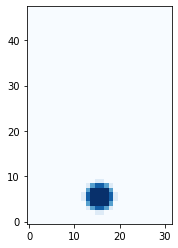

In [3]:
for frame in range(30):
  print('Building graph for frame %d' % frame)
  world.step(dt=0.5)
  states.append(fluid.state)


print('Computing frames...')
pylab.imshow(np.concatenate(session.run(fluid.density).data[...,0], axis=1), origin='lower', cmap='magma')

In [5]:
#Define loss function
#Want the densities of the right blob to match the ones of the left blob (target)
arr = np.load("t_only/sim_000001/density_000099.npz")

target = arr['arr_0']
loss = math.l2_loss(fluid.density.data[0:,...] - target)
optim = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss)
#optim = tf.train.AdadeltaOptimizer(learning_rate=5).minimize(loss)
session.initialize_variables()
print('Initial loss: %f' % session.run(loss))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Initial loss: 172709.562500


In [6]:
#Run optimization

for optim_step in range(300):
  print('Running optimization step %d. %s' % (optim_step, '' if optim_step else 'The first step sets up the adjoint graph.'))
  _, loss_value = session.run([optim, loss])
  print('Loss: %f' % loss_value)

Running optimization step 0. The first step sets up the adjoint graph.
Loss: 172709.562500
Running optimization step 1. 
Loss: 126167.617188
Running optimization step 2. 
Loss: 103802.359375
Running optimization step 3. 
Loss: 89911.882812
Running optimization step 4. 
Loss: 80779.914062
Running optimization step 5. 
Loss: 74371.281250
Running optimization step 6. 
Loss: 69633.625000
Running optimization step 7. 
Loss: 66030.492188
Running optimization step 8. 
Loss: 63209.546875
Running optimization step 9. 
Loss: 60918.523438
Running optimization step 10. 
Loss: 58989.312500
Running optimization step 11. 
Loss: 57319.937500
Running optimization step 12. 
Loss: 55858.753906
Running optimization step 13. 
Loss: 54581.003906
Running optimization step 14. 
Loss: 53442.855469
Running optimization step 15. 
Loss: 52424.421875
Running optimization step 16. 
Loss: 51494.070312
Running optimization step 17. 
Loss: 50653.917969
Running optimization step 18. 
Loss: 49901.312500
Running optimiza

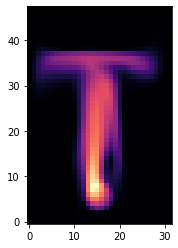

In [7]:
#See what this thing did

pylab.imshow(np.concatenate(session.run(fluid.density).data[...,0], axis=1), origin='lower', cmap='magma')

In [8]:
#Checkout the optimized velocity field

optimized_velocity_field = session.run(states[0].velocity).at_centers()

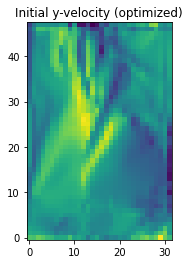

In [9]:
pylab.title('Initial y-velocity (optimized)')
pylab.imshow(np.concatenate(optimized_velocity_field.data[...,0], axis=1), origin='lower')

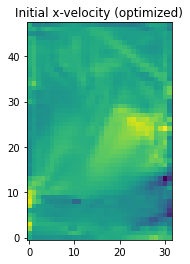

In [10]:
pylab.title('Initial x-velocity (optimized)')
pylab.imshow(np.concatenate(optimized_velocity_field.data[...,1], axis=1), origin='lower')

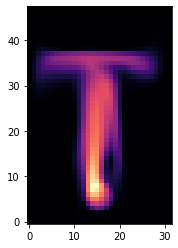

In [12]:
#Saving the optimized density fields as images

if (save_imgs):
    for i in range(len(states)):
        save_name = "t_vis/t_frame%03d.png"
        pylab.imshow(np.concatenate(session.run(states[i].density).data[...,0], axis=1), origin='lower', cmap='magma')
        pylab.savefig(save_name % (i), bbox_inches='tight')
